Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline

Download the data from the source website if necessary.

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [14]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207
anarchism
originated
as


Build the dictionary and replace rare words with UNK token.

In [18]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'a', 'anarchism', 'term', 'originated', 'term', 'of', 'as']


Train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.138786
Nearest to this: abbey, redshifts, bouncer, mercator, hindustan, pfaff, big, immunoglobulin,
Nearest to they: cranston, iuds, bloodlines, prevent, clinics, df, scheldt, duke,
Nearest to were: district, riddles, intangible, coerce, lagrange, itasca, ostracized, fulgencio,
Nearest to on: crooks, boxer, skirmish, alf, murderer, resurrect, angora, practise,
Nearest to be: telepathy, fencer, externalization, geophysical, sucre, acl, greeted, stealth,
Nearest to i: xenosaga, bremer, vows, checked, money, synonymously, ridinghood, concerns,
Nearest to UNK: repose, vocational, occuring, rhythms, killer, mandrakesoft, czes, ready,
Nearest to five: declaring, synthesized, huldrych, publicizing, regulator, warmth, commodity, ifs,
Nearest to are: capacities, cynicism, ashford, greek, peshawar, strassman, micron, teenage,
Nearest to while: choice, for, cirrhosis, toba, archeological, tithes, fluids, programmes,
Nearest to four: brains, mingled, arrive, s

Average loss at step 52000: 3.437840
Average loss at step 54000: 3.424366
Average loss at step 56000: 3.437012
Average loss at step 58000: 3.403697
Average loss at step 60000: 3.393196
Nearest to this: it, which, that, tutored, the, there, any, some,
Nearest to they: we, there, you, he, not, these, she, it,
Nearest to were: are, was, those, have, had, dusting, be, been,
Nearest to on: upon, in, sectarianism, scarlett, through, around, into, hazlitt,
Nearest to be: been, being, refer, was, telepathy, were, is, become,
Nearest to i: ii, you, we, g, condiments, vietnam, naturalisation, someone,
Nearest to UNK: discography, proposition, o, commissions, antibacterial, aalen, spoken, compassionate,
Nearest to five: four, six, three, eight, seven, nine, zero, two,
Nearest to are: were, is, have, pluto, include, although, those, conceptually,
Nearest to while: although, though, when, however, after, before, but, including,
Nearest to four: six, five, eight, seven, three, nine, two, zero,
Neare

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

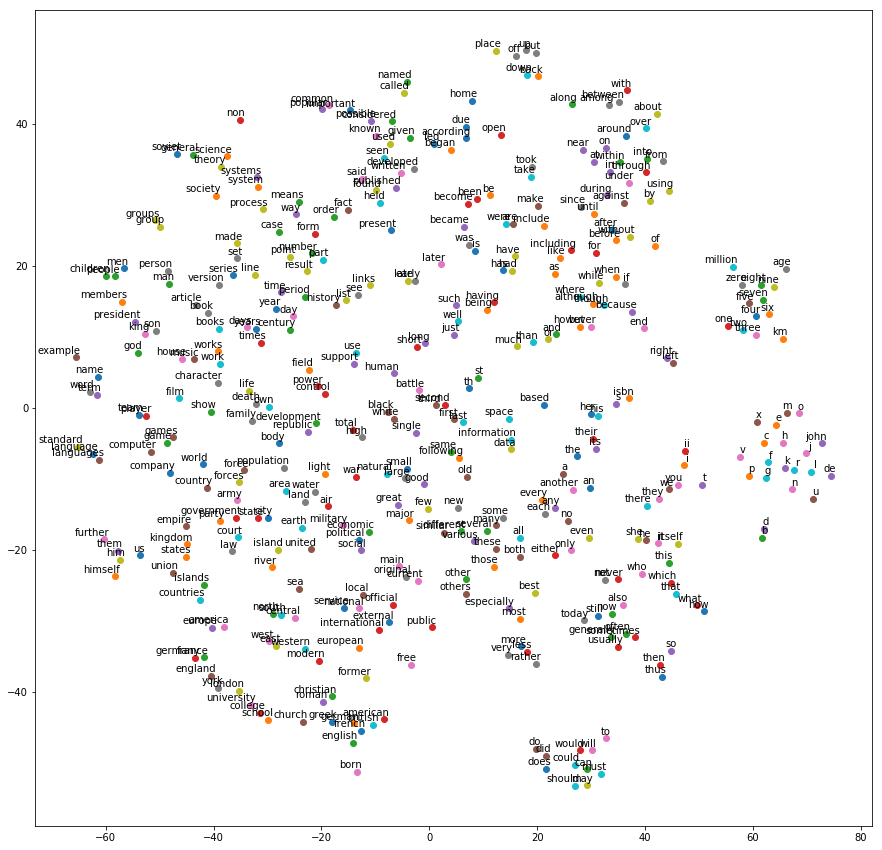

In [11]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

https://gist.github.com/yxtay/a94d971955d901c4690129580a4eafb9

In [28]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, context_window=1)
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

214 ii 2 of -> 757 lord
757 lord 2187 destruction -> 2 of
2 of 0 UNK -> 2187 destruction
2187 destruction 12908 persist -> 0 UNK
0 UNK 14 for -> 12908 persist
12908 persist 12 as -> 14 for
14 for 185 long -> 12 as
12 as 12 as -> 185 long


In [29]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # just for testing
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [30]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
bag_window = 2  # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Construct the variables for the NCE loss
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    #embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    # take mean of embeddings of context words for context embedding
    embed_context = tf.reduce_mean(embeds, 1)
    
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_context, labels=train_labels,
                       num_sampled=num_sampled, num_classes=vocabulary_size))

    
    # Compute the softmax loss, using a sample of the negative labels each time.
    #loss = tf.reduce_mean(
    #    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
    #                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    # optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    
    # Add variable initializer.
    init = tf.initialize_all_variables()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [31]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    #init.run()
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 257.957275
Nearest to s: olympia, een, upstairs, sibley, beg, entanglements, uae, kagoshima,
Nearest to on: explosive, agape, flynn, stimulates, reynolds, avengers, slap, spots,
Nearest to also: meridian, euboea, phenyl, subnet, mv, screen, salk, gn,
Nearest to these: dolls, anthropological, organ, delaunay, exists, counterparts, hung, specifications,
Nearest to eight: frog, othello, linker, fielded, guerra, sick, tenses, angiosperms,
Nearest to about: joker, ina, incl, remainders, malwa, pigs, buda, hendricks,
Nearest to to: bing, archaea, cannon, einsteinium, geese, hurrians, dessert, disintegrate,
Nearest to would: treacherous, unlucky, perpetual, choreography, angra, interbreeding, bastiat, rail,
Nearest to other: arresting, leiden, uncreated, bleu, synopsis, bennett, belial, recommending,
Nearest to have: ethologists, feldspar, trapezohedron, fiore, pepin, postgresql, spada, conception,
Nearest to is: catalysts, stockhausen, derogatory, nostalgi

Average loss at step 52000: 4.772931
Average loss at step 54000: 4.747713
Average loss at step 56000: 4.542039
Average loss at step 58000: 4.637443
Average loss at step 60000: 4.628604
Nearest to s: his, her, colleges, essay, newspapers, opposite, wire, le,
Nearest to on: flynn, assyrian, gold, desire, under, novella, rejoin, theater,
Nearest to also: dance, width, primarily, credited, which, alien, maj, similar,
Nearest to these: some, all, many, other, now, they, mere, several,
Nearest to eight: nine, seven, zero, five, six, four, yes, amaranthus,
Nearest to about: while, joker, attention, males, merchant, visible, chirality, li,
Nearest to to: will, against, bing, would, phenomenon, mats, perpendicular, stick,
Nearest to would: will, may, could, can, must, might, should, does,
Nearest to other: these, leiden, both, arbitration, different, mainstream, playoff, wholly,
Nearest to have: has, had, having, be, are, were, assaults, extent,
Nearest to is: was, are, became, has, be, gives, 

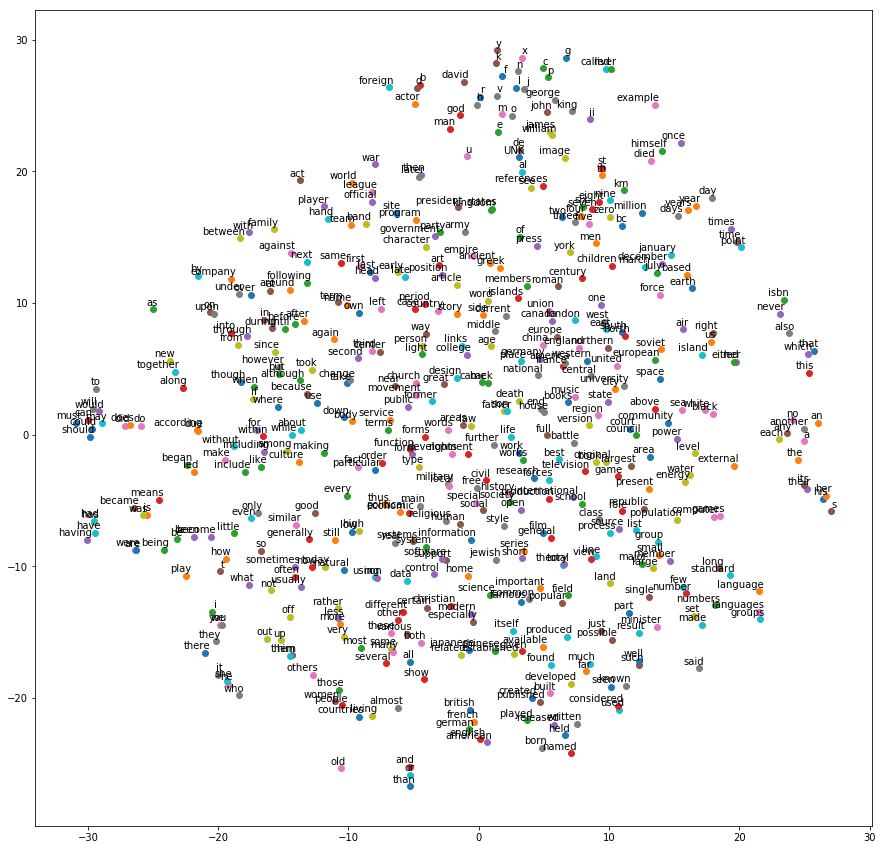

In [33]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()


try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    #plot_with_labels(low_dim_embs, labels)
    plot(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")

In [34]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])

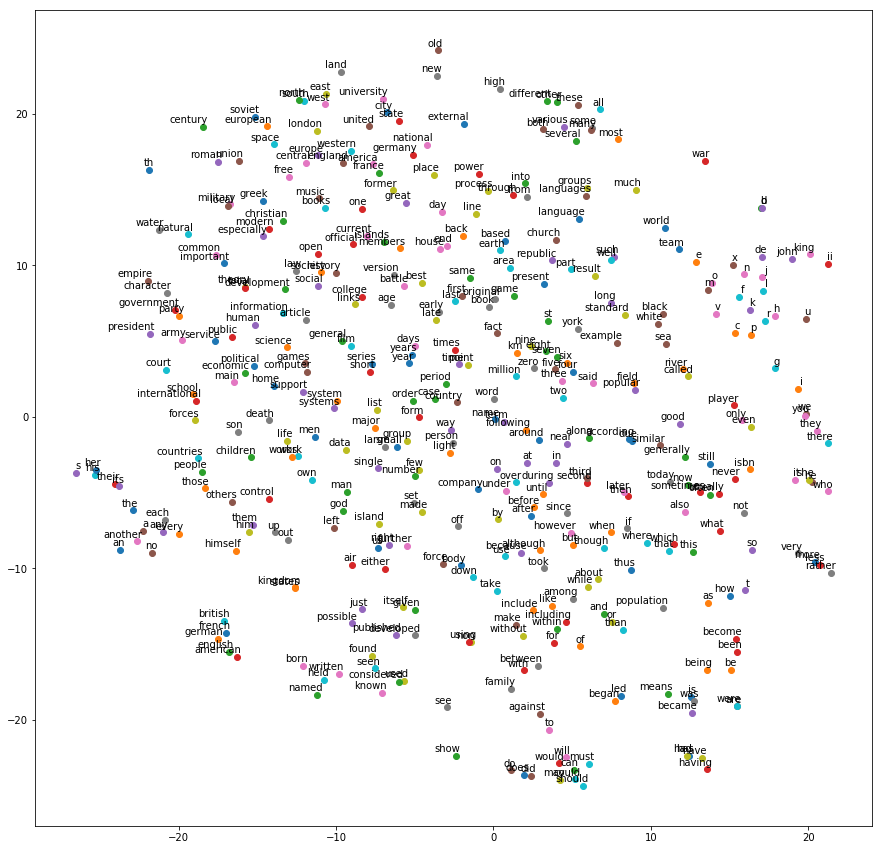

In [35]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()


words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)